In this post, I'll discuss a very simple language model: n-grams! To keep things simple we will be concerned with the creation of single words. The goal will be to have a language model that learns from a corpus of (first-)names, and is able to create new *name-sounding* names. The idea for this comes from Andrej Karpahy's [lecture series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) on Neural Networks.

Like most (any?) language model, n-gram models can be used to predict the next **token** in a sequence. The *n* in n-gram relates to the length of the used **context**. Bi-gram models, only use the previous token as context, tri-gram models use the last two tokens to predict the following token.

:::{.callout-note}
- **token**: When creating language models, we have to decide on the granularity of the data. We can for example build a model that deals with single characters (a-z), entire words or word-parts. This decision is formalized by the use of a **dictionary**, which is the list of unique elements occuring in the data. For the character level model we are building, the dictionary will consist of all letters (a-z). The elements of the dictionary are referred to as tokens. Besides the letters a-z, we will also add a token to the dictionary reflecting the start and end of names.
- **context**: Analog to the "features" ($X$) concept in machine learning, as opposed to the "labels" ($y$). The context thus relates to the data that is used when creating a prediction for the next character in a sequence. 
:::

Let's clearify what we mean with *prediction of the next token*: an n-gram model learns a probability distribution over any of the tokens that can follow from any of the possible contexts. A bi-gram character-level model has thus a learned probability distribition over all the characters (*a* through *z*, and let's add a token to denote the *end of a word*, so 26+1 tokens) that can follow from any character.

The simplest possible way to *learn* a probability distribution from training data, is by simply keeping track of the statistics in the training corpus: 

- iterate through all the n-grams in the data
- count the occurences of each n-gram.

If we then normalize these counts (by dividing through the sum) we have a probability distribution!

## Data

Everything starts with training data:

In [ ]:
from functools import reduce
from pathlib import Path
from urllib.request import urlretrieve
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *

In [ ]:
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

In [ ]:
with open(path, 'r') as f:
    lines = f.read().splitlines()

print('first 5 names in array: ', end=' ')
print(lines[0:5])
print(f'{len(lines)=}')

first 5 names in array:  ['emma', 'olivia', 'ava', 'isabella', 'sophia']
len(lines)=32033


## Bi-gram count model

Let's build the bigram count model outlined above:

In [ ]:
unique_chars = list(set("".join(lines)))
unique_chars.sort()
dictionary = unique_chars + ['.']
print(f'{dictionary=}')
print(f'{len(dictionary)=}')

dictionary=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.']
len(dictionary)=27


From the dictionary we create a mapping from token to integer. We will use this mapping to encode our tokens (characters) into integers. This is called **numericalisation**:

In [ ]:
c2i = {c:i for i, c in enumerate(dictionary)}
i2c = {i:c for i, c in enumerate(dictionary)}

And just for clarity, let's have a look at the bigrams for the first name in the dataset:

In [ ]:
cutoff = round(len(lines) * 0.8)
train_lines = lines[:cutoff]
val_lines = lines[cutoff:]

name = "." + train_lines[0] + "."
print(f'name : "{name}"')
print('bigrams:')
bigrams = zip(name[:-1], name[1:])
for bigram in bigrams:
    context = bigram[0]
    next_char = bigram[1]
    print(f'{context} --> {next_char} \t numericalized: {c2i[context]:>2} --> {c2i[next_char]:>2}')

name : ".emma."
bigrams:
. --> e 	 numericalized: 26 -->  4
e --> m 	 numericalized:  4 --> 12
m --> m 	 numericalized: 12 --> 12
m --> a 	 numericalized: 12 -->  0
a --> . 	 numericalized:  0 --> 26


To keep track of the occurences we will employ a matrix of size $[27, 27]$ (the size of the dictionary). The rows reflect the possible values of the context and the columns reflect any possible character following this context. We will initialize this matrix with zeros, and "add 1" to the cell matching any n-gram we encounter:

In [ ]:
counts = torch.zeros([27,27], dtype=int)              # intialize counts matrix
for name in train_lines:                              # iterate through all the names
    name = "." + name + "."                           # add start and end token to the name
    bigrams = zip(name[:-1], name[1:])                # create all bigrams for the name (list of tuples)
    for bigram in bigrams:                            # iterate through bigrams
        counts[c2i[bigram[0]], c2i[bigram[1]]] +=1    # increase the counts in the matrix for the encountered bigram

And let's visualize this count matrix. On the vertical axis (the rows of the matrix) we have the "context" characters and on the horizontal axis (the columns of the matrix) the characters that follow from this context are shown. Bright (white) colors mean low counts, and dark blue colors means high counts. The first observation is that the matrix is actually quite sparse. Many bigrams appear very few times, and a couple of ones occur very frequently. We further observe:

- Looking at the first row: an "a" is followed very often either with an "n" or even more often by a ".", meaning the "a" is the last character in the word
- Looking at the last row: names start most often with an "a"

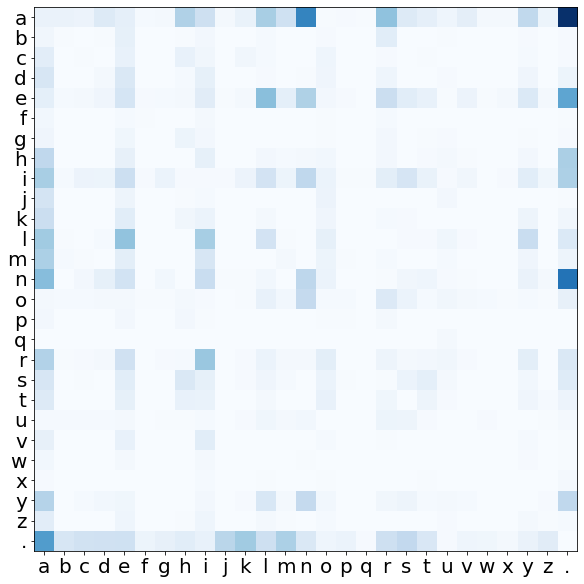

In [ ]:
#| code-fold: true

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(counts, cmap='Blues');
ax.set_xticks(list(range(0,27)), list(c2i.keys()));
ax.set_yticks(list(range(0,27)), list(c2i.keys()));
ax.tick_params(axis='both', which='major', labelsize=20);

Let's use this language model to generate some new names:

In [ ]:
# Normalize over the rows
probs = counts / counts.sum(dim=1, keepdim=True)

In [ ]:
g = torch.Generator().manual_seed(42)

names = []
for i in range(10):                           # generate 20 names
    name = '.'                                # initialize each name with a starting token
    while True:                               # loop until break
        ctx = c2i[name[-1]]                   # index of last character
        pdf = probs[ctx]                      # pdf over characters that follow from last character
        s = torch.multinomial(pdf, 1, generator=g) # draw a sample given the pdf
        c = i2c[s.item()]                     # transform to character
        name += c                             # append new character to name
        if c == '.':                          # stop sampling upon reaching an end of word token
            names.append(name)                # store away sampled name
            break

In [ ]:
names

['.akyleloniatanacaroleynn.',
 '.con.',
 '.thmarie.',
 '.di.',
 '.n.',
 '.kahannoa.',
 '.jadde.',
 '.ethann.',
 '.dalaydah.',
 '.loeshana.']

Hmm, not super great names.. I guess it's not surprising given the simplicity of this model. 

How could we improve on this result? The most obvious way, would be to increase the context length (3-grams, 4-grams etc). This way, the model has more knowledge of what previously occurred, and can possibly create better predictions for the next character. This will probably work fine for n=3 and 4, but with even larger values of n, we will run into problems. The reason for this in short is that the counts matrix is going to be extremely sparse as the amount of rows (= the amount of possible contexts) increases with $27^n$.

We thus have to come up with another strategy to increase the performance of our model, for which we turn to neural networks😏

## Neural network

It turns out that the count model described above, has an equivalence to a very simple neural network that's composed of an embedding layer and uses cross-entropy loss.

:::{.callout-note}
An **embedding layer** is a layer that is used to "encode" our data, which roughly translates to the way we input our data into a neural network. We already saw above that we numericalized our characters (a-z) as integers. We will have to do something similar for our neural network, since we can't input characters into a neural network. However instead of feeding integers into our network, we can also employ an embedding layer, which will basically create a vector out of our integers. Every integer will obtain it's own vector, and the values contained in the vector will be learned during training. The advantage of this, is that the model can easily learn different "attributes" that make up the individual tokens. For example, it could use the first dimension in the vector to denote whether the token is a vowel (a, e, i, o, u) and the second dimension to represent the likelihood of starting a sentence.
:::

If we create an embedding layer with (embedding) dimensions equal to that of the dictionary, the outputs of this layer will also conform to the size of our dictionary, e.g. `[batch_size * 26]`. These raw outputs of our model are referred to as logits, and they can be anything: positive, negative, small or large. We can exponentiate these logits to get numbers that are always positive, and these values are equivalent to values in the "counts" matrix. We can then normalize these exponentiated logits row-wise, to get to probabilities. And finally adding a negative log-likelihood loss on these probabilities is guiding the network to establish an embedding matrix with weights that are practically identical to the (log transformed) counts matrix from above. The combined operation of exponentiating, normalizing and negative log-likelihood is what we call cross-entropy loss. See also an earlier blog [post](https://lucasvw.github.io/posts/05_crossentropy/).

We are going to train this model using [`nntrain`](https://lucasvw.github.io/posts/08_nntrain_setup/), the small neural network training library we have been created before.

Let's start with the data, the datasets and the dataloaders. And let's make the dataset generic so that it can create datasets for any n-gram model we wish. To do so, let's have a quick look how 2-grams, 3-grams and 4-grams look for the first name in the data *Emma*:

In [ ]:
#| code-fold: true

name = lines[0]
name = '.' + name + '.'
print('2-grams:')
for i in zip(name[:-1], name[1:]):
    print(i[0], '--->', i[1])

2-grams:
. ---> e
e ---> m
m ---> m
m ---> a
a ---> .


In [ ]:
#| code-fold: true

name = lines[0]
name = '..' + name + '.'
print('3-grams:')
for i in zip(name[:-2], name[1:-1], name[2:]):
    print(i[0], i[1], '--->', i[2])

3-grams:
. . ---> e
. e ---> m
e m ---> m
m m ---> a
m a ---> .


In [ ]:
#| code-fold: true

name = lines[0]
name = '...' + name + '.'
print('4-grams:')
for i in zip(name[:-3], name[1:-2], name[2:-1], name[3:]):
    print(i[0], i[1], i[2], '--->', i[3])

4-grams:
. . . ---> e
. . e ---> m
. e m ---> m
e m m ---> a
m m a ---> .


We observe:

- irrespective of n, we always end up with the same amount of samples
- when we increase the context to n=3 and n=4, we need to add additional start-word tokens to make sure we don't skip the first sample(s)

Let's create a dataset in which we can set the value of `n`:

In [ ]:
class NgramDataset():
    def __init__(self, lines, n=2):
        self.x = []    # store the xs, the context, the left hand side of the bigram
        self.y = []    # store the ys, the labels, the right hand side of the bigram
        for line in lines:           
            x = '.'*(n-1)         # the first x is always full of start word tokens
            for y in line + '.':  # the first y is always the first letter of the name
                self.x.append([c2i[xi] for xi in x])  # convert to int and store
                self.y.append(c2i[y])                 # convert to int and store
                x = (x + y)[1:]                       # update x
        self.x = torch.tensor(self.x)                 # from list to tensor 
        self.y = torch.tensor(self.y).squeeze()       # from list to tensor
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

Next, let's create the model, which should also be able to deal with n-grams. Instead of using PyTorch's `nn.Embedding` layer, we will use a custom weight matrix which we will use as weight matrix for the embedding layer. The reason for this, is that `nn.Embedding` is only two dimensional. For an n-gram of n > 2, we would then have to stack-up all the different possible character combinations of the context in the row dimension. This is a bit tedious to implement, so instead we will use an explicit n-dimensional weight tensor. For the trigram this means: the first (second) dimension is for the first (second) character in the context, and the last dimension is for the label.

In [ ]:
class NgramNet(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.n = n
        self.embedding = nn.Parameter(torch.randn((27,)*n).requires_grad_())
        
    def forward(self, x):
        # logits are obtained by indexing into the embedding matrix
        logits = self.embedding[[x[:,i] for i in range(0,self.n-1)]]
        return logits

In [ ]:
train_ds = NgramDataset(train_lines)
val_ds = NgramDataset(val_lines)

bs = 10000
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2)
dls = DataLoaders(train_loader, val_loader)

epoch,mode,loss
0,train,3.121
0,eval,2.865
1,train,2.676
1,eval,2.803
2,train,2.642
2,eval,2.791
3,train,2.636
3,eval,2.789
4,train,2.635
4,eval,2.787


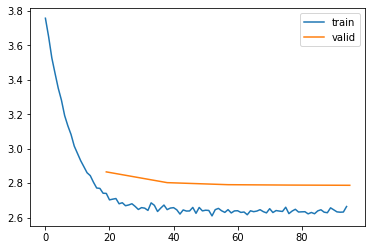

In [ ]:
m = NgramNet()
n_2gram = m.embedding.numel()

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

l = Learner(m, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs)
l.fit(5, lr=1e-1)

Now, let's patch our model with a `generate()` method, returning names sampled from the learned representation. We can pass in a generator to make sure we get the same random behavior as we have seen above when generating names with the counts model:

In [ ]:
@fc.patch
def generate(self:NgramNet, n=10, generator=None):
    names = []
    for i in range(n):
        name = '.' * (self.n-1)
        while True:
            # the following 2 lines are a bit ugly, but couldn't find a better way
            # cleaner way to make this work for both n=2 and n>2, indexing performs 
            # differently for both cases
            idx = [c2i[i] for i in name[-(self.n-1):]]
            logits = reduce(lambda emb, i: emb[i], idx, self.embedding).detach().cpu()
            s = torch.multinomial(F.softmax(logits, dim=0), 1, generator=generator)
            c = i2c[s.item()]
            name += c
            if c == '.':
                names.append(name)
                break
    return names

In [ ]:
m.generate(generator=torch.Generator().manual_seed(42))

['.aavheennlatanacaeoaeynnhr.',
 '.e.',
 '.tlmi.',
 '.meh.',
 '.l.',
 '.n.',
 '.i.',
 '.mynmoa.',
 '.jlndy.',
 '.ethmen.']

As you can see, these names are extremely similar to the ones we created above with the counts based model, and this is actually pretty surprising. One model was based on common sense, logic and simple counting. The other model on neural networks, embedding layers, loss functions, training loops, backward passes etc etc. Nonetheless, the results are the same!

The reason for this, is that the network architecture (and the loss) implies mathematical equivalence between both approaches. This can probably be shown explicitly with lots of complicated math, which I am not even going to try.

We can also have a look at both the weight matrices to see that the embedding matrix is extremely similar to the counts matrix:

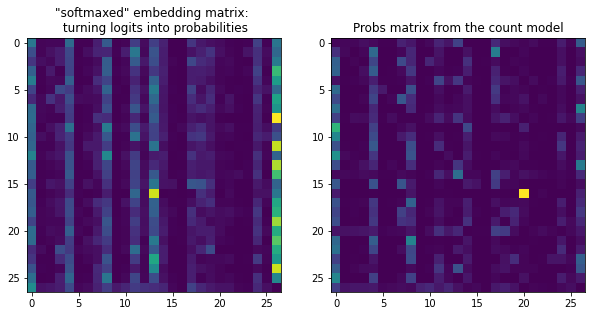

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(F.softmax(m.embedding.detach().cpu(), dim=1).numpy());
axs[0].set_title('"softmaxed" embedding matrix: \n turning logits into probabilities');
axs[1].imshow(probs);
axs[1].set_title('Probs matrix from the count model');

## Next steps

This extremely cool equivalence means we can forget the count model alltogether and use our new neural network paradigm to improve performance. In other words, we can use any trick in the box for training neural networks! The first we will see in our next post: a simple MLP model from Y. Bengio et al described in the paper "A Neural Probabilistic Language Model". But let's quickly train a couple of networks with higher n-grams to see how that goes:

epoch,mode,loss
0,train,2.975
0,eval,2.591
1,train,2.276
1,eval,2.455
2,train,2.184
2,eval,2.438
3,train,2.168
3,eval,2.433
4,train,2.163
4,eval,2.435


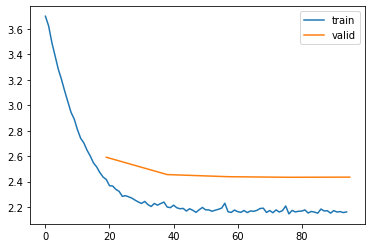

In [ ]:
ngram = 3

train_ds = NgramDataset(train_lines, n=ngram)
val_ds = NgramDataset(val_lines, n=ngram)

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2)

dls = DataLoaders(train_loader, val_loader)

m = NgramNet(n=ngram)
n_3gram = m.embedding.numel()

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

l = Learner(m, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs)
l.fit(5, lr=1e-1)

Evaluation Loss went down from 2.597 for the bi-gram model to 2.437 for the tri-gram model. Let's try a 4-gram model as well:

epoch,mode,loss
0,train,3.042
0,eval,2.681
1,train,2.170
1,eval,2.460
2,train,1.971
2,eval,2.431
3,train,1.916
3,eval,2.431
4,train,1.894
4,eval,2.442


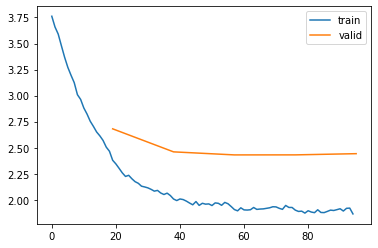

In [ ]:
ngram = 4

train_ds = NgramDataset(train_lines, n=ngram)
val_ds = NgramDataset(val_lines, n=ngram)

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2)

dls = DataLoaders(train_loader, val_loader)

m = NgramNet(n=ngram)
n_4gram = m.embedding.numel()

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

l = Learner(m, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs)
l.fit(5, lr=1e-1)

And here, we start to see problems. The train loss is still getting better (1.894 for 4-gram vs 2.163 for 3-gram) but the evaluation loss is worse (2.442 for 4-gram vs 2.435 for 3-gram). Let's also quickly compare the number of elements in the embedding layer for the 2, 3 and 4-gram models.

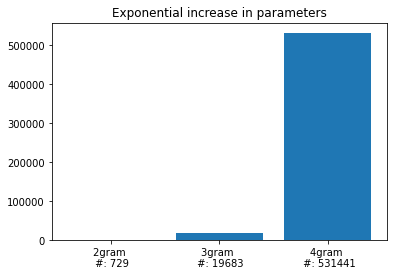

In [ ]:
fig, ax = plt.subplots(1)
ax.bar(range(0,3), [n_2gram, n_3gram, n_4gram])
ax.set_xticks(range(0,3), [f'2gram \n #: {n_2gram}', f'3gram \n #: {n_3gram}', f'4gram \n #: {n_4gram}']);
ax.set_title('Exponential increase in parameters');